In [2]:
# IDEA: Add neck to the posture map?
from IPython import get_ipython

# QT for movable plots
%load_ext autoreload
%autoreload 2

import time, os, sys, shutil
from utils.fitting_utils import *

# for math and plotting
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# %matplotlib notebook
# %matplotlib inline

# %matplotlib widget
%matplotlib qt

from itertools import compress # for list selection with logical
from tqdm import tqdm

from multiprocessing import Process

# ALLSO JIT STUFF
from numba import jit, njit

# and pytorch
import torch

import sys, os, pickle
# import cv2
from colour import Color
import h5py
from tqdm import tqdm, tqdm_notebook
import glob
import itertools

In [3]:
from utils.analysis_tools import adjust_spines,cmpl

/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/analysis_tools.py:74: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  matplotlib.rcParams['mathtext.fallback_to_cm'] = False
/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/analysis_tools.py:74: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  matplotlib.rcParams['mathtext.fallback_to_cm'] = False
/home/chrelli/git/3ddd_mouse_tracker/analysis/utils/analysis_tools.py:74: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  matplotlib.rcParams['mathtext.fallback_to_cm'] = False


# Load tracked data and plot a frame

In [4]:
#load the tracked data!
data_folder = 'example_data/tracking/'


top_folder_0 = '/media/chrelli/Data0/recording_20200821-131033'
top_folder_1 = '/media/chrelli/Data1/recording_20200821-131033'

# validation dataset with LASER ON 90 fps
top_folder_0 = '/media/chrelli/Data0/recording_20200828-114251'
top_folder_1 = '/media/chrelli/Data1/recording_20200828-114251'

# Data with female partner 3500 exposure
top_folder_0 = '/media/chrelli/Data0/recording_20201110-102009/'
top_folder_1 = '/media/chrelli/Data1/recording_20201110-102009/'


data_folder = top_folder_0


with open(data_folder +'/tracked_behavior.pkl', 'rb') as f:
    tracked_behavior = pickle.load(f)
print(tracked_behavior.keys())

# load ALL the frames as jagged lines 
with h5py.File(data_folder+'/pre_processed_frames.hdf5', mode='r') as hdf5_file:
    print(hdf5_file.keys())
    print(len(hdf5_file['dataset']))
    jagged_lines = hdf5_file['dataset'][...] 


dict_keys(['var', 'ivar', 'body_constants', 'start_frame', 'end_frame', 'has_implant', 'tracking_holder', 'guessing_holder', 'data_folder'])
<KeysViewHDF5 ['dataset']>
73123


In [5]:
from utils.cuda_tracking_utils import unpack_from_jagged, cheap4d
# kill first 6 secs of the frames (delay is ~180)
start_frame = 10*60
pos, pos_weights, keyp, pkeyp, ikeyp = unpack_from_jagged(jagged_lines[start_frame])
print(ikeyp)
print(pos.shape)

cheap4d(pos,keyp,ikeyp)
# fig = plt.gcf()
# plt.title("N positions is {}".format(pos.shape))


[1 1 3 1 1 2 1 1 2 3 2]
(3163, 3)


In [6]:
print(tracked_behavior['tracking_holder'].shape)
print(tracked_behavior['var'])
print(tracked_behavior['ivar'])
print(tracked_behavior.keys())


(18, 71722)
['b', 'c', 's', 'psi', 'theta', 'phi', 'x', 'y', 'z', 'b', 'c', 's', 'theta', 'phi', 'x', 'y', 'z', 'frame']
['b0', 'c0', 's0', 'psi0', 'theta0', 'phi0', 'x0', 'y0', 'z0', 'b1', 'c1', 's1', 'theta1', 'phi1', 'x1', 'y1', 'z1', 'frame']
dict_keys(['var', 'ivar', 'body_constants', 'start_frame', 'end_frame', 'has_implant', 'tracking_holder', 'guessing_holder', 'data_folder'])


In [7]:
#%% Plot tracked data to see that everything is fine
plt.close('all')
plt.figure(figsize=(15,20))

tracking_holder = tracked_behavior['tracking_holder']
guessing_holder = tracked_behavior['guessing_holder']


def wrap_angles(phases):
    phases = (phases + np.pi) % (2 * np.pi) - np.pi
    return phases

    if units[i] == 'rad' and do_wrapping:
        dat0 = wrap_angles(dat0)
        dat1 = wrap_angles(dat1)

NNN = ['b','c','s','psi','theta','phi','x','y','z','b','c','s','theta','phi','x','y','z']
for ii,name in enumerate(NNN):
    plt.subplot(len(NNN),1,ii+1)
    index = np.arange(tracking_holder.shape[1])
    
    dat = tracking_holder[ii,:]
    if ii in [0,1,8,9]:
        dat = wrap_angles(dat)
    
    plt.plot(index[:],dat,'.')
#     plt.plot(index[:],guessing_holder[ii,:])
    plt.ylabel(str(ii)+'_'+name)
plt.show()
 

In [17]:
if tracked_behavior['has_implant']:
    theta0 = tracking_holder[4,:]
    phi0 = tracking_holder[5,:]
else:
    theta0 = tracking_holder[3,:]
    phi0 = tracking_holder[4,:]
    
# theta0 = tracking_holder[3+9,:]
# phi0 = tracking_holder[4+9,:]

plt.figure()
plt.plot(theta0,phi0,'.', alpha = .05)
plt.show()

In [9]:
# check out if the changes are slamming up against the clamps
plt.figure(figsize = (20,10))
N_params = tracking_holder.shape[1]-1
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.hist(np.diff(tracking_holder[ii,:]),100)
    sd = np.std( np.diff(tracking_holder[ii,:]) )
    plt.title("sd: {:0.3f}".format(sd))
plt.subplots_adjust(hspace = .5)    
plt.show()



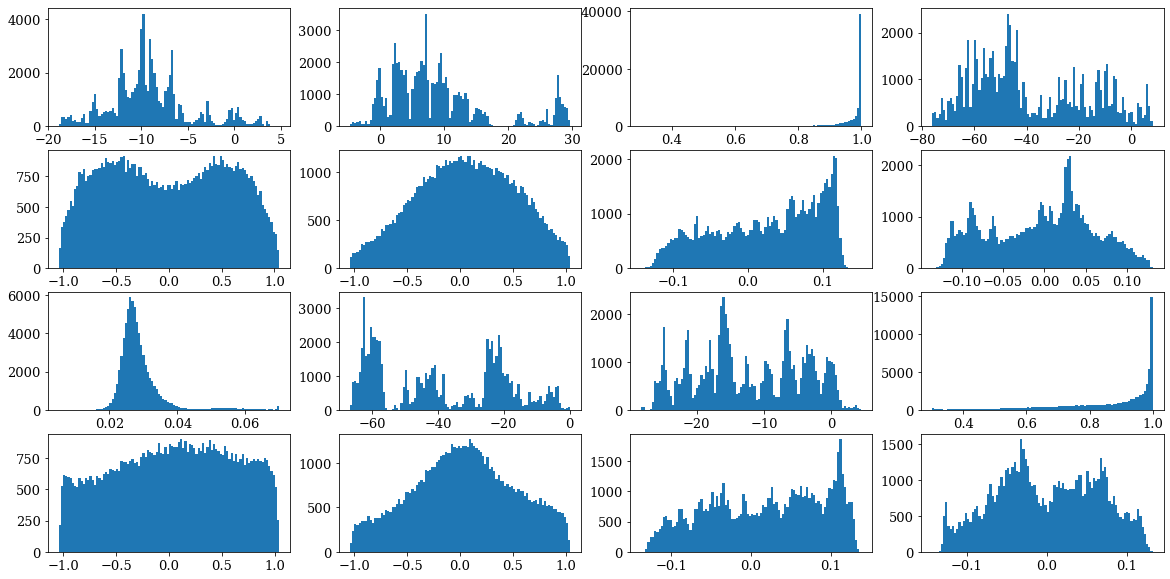

In [9]:
plt.figure(figsize = (20,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.hist(tracking_holder[ii,:],100)
plt.show()

# Plot a raw frame, check that the plotter works

20000
18600
i_trace_start is 17640 and i_frame is 18600
['nose']
['nose']


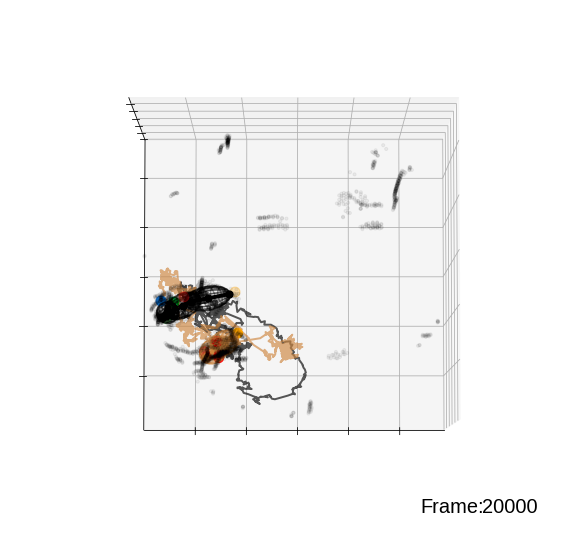

In [10]:
from utils.analysis_tools import VideoPlotMachine,PlotMachine,PlotMachine_noimpl
# take a list of frames, calculate body supports and plot as a kind of decaying trail, with some decay and lengthm maybe the center of the nose??
plt.close('all')

has_implant = tracked_behavior['has_implant']
if has_implant:
    Plotter = PlotMachine_noimpl(tracked_behavior,jagged_lines, has_implant= has_implant)
else:
#     Plotter = PlotMachine(tracked_behavior,jagged_lines)
    Plotter = PlotMachine_noimpl(tracked_behavior,jagged_lines)

#Plotter.kernel_smoothing(9)

fps = 30
example_frame = 20000

n_fine = 5
# Plotter.make(example_frame,view_override = [55.0,90.])

Plotter.make(example_frame,view_override = [85.0,90.])



# Here we copy the smoothing functions, so they are easy to make plots from 

In [11]:
sigma_process = .01
sigma_measure = .015            
            
from filterpy.common import kinematic_kf,Q_discrete_white_noise
from filterpy.kalman import FixedLagSmoother

def kalman1_3D(tr,sigma_process,sigma_measure,dt = 1/60):
    # make first order kinematic kalman filter
    cv = kinematic_kf(dim=3, order=1, dt = dt) 
    cv.R = np.eye(3) * sigma_measure**2
    G = np.array([[0.5 * dt**2, dt]], np.float32).T
    Q0 = np.matmul(G, G.T) * sigma_process**2

    for i in [0,2,4]:
        cv.Q[i:(i+2),i:(i+2)] = Q_discrete_white_noise(dim=2, dt=dt, var=sigma_process**2)
    #     cv.Q[i:(i+2),i:(i+2)] = Q0
    cv.P = np.ones((cv.dim_x,cv.dim_x))*0.001 +.0001
    
    kalman_estimate = []
    # initialize
    cv.x =  np.array([[ tr[0,0],0,tr[0,1],0,tr[0,2] ,0 ]]).T
    cv.update(tr[i,:])
    for i in tqdm(range(tr.shape[0])):
        cv.predict()
        cv.update(tr[i,:][:,np.newaxis])

        kalman_estimate.append(cv.x)

    kalman_estimate = np.hstack(kalman_estimate)    
    tr_filtered = kalman_estimate[[0,2,4],:].T
    return tr_filtered

def fls1_3d(tr,sigma_process,sigma_measure,dt = 1/60,N_lag = 16):
    # make first order kinematic kalman filter
    cv = kinematic_kf(dim=3, order=1, dt = dt) 
    cv.R = np.eye(3) * sigma_measure**2
    G = np.array([[0.5 * dt**2, dt]], np.float32).T
    Q0 = np.matmul(G, G.T) * sigma_process**2

    for i in [0,2,4]:
        cv.Q[i:(i+2),i:(i+2)] = Q_discrete_white_noise(dim=2, dt=dt, var=sigma_process**2)
    #     cv.Q[i:(i+2),i:(i+2)] = Q0
    cv.P = np.ones((cv.dim_x,cv.dim_x))*0.001 +.0001
    
    kalman_estimate = []
    # initialize
    cv.x =  np.array([[ tr[0,0],0,tr[0,1],0,tr[0,2] ,0 ]]).T
    
    # also make an FLS smoother 
    fls = FixedLagSmoother(dim_x=6, dim_z=3, N=N_lag)

    fls.x = np.copy(cv.x)
    fls.F = np.copy(cv.F)
    fls.H = np.copy(cv.H)
    fls.P = np.copy(cv.P)
    fls.R = np.copy(cv.R)
    fls.Q = np.copy(cv.Q)
    
    for i in tqdm(range(tr.shape[0])):
        cv.predict()
        cv.update(tr[i,:][:,np.newaxis])
        fls.smooth(tr[i,:][:,np.newaxis])
        kalman_estimate.append(cv.x)

    kalman_estimate = np.hstack(kalman_estimate)    
    fls_estimate = np.hstack(fls.xSmooth)
    tr_filtered = kalman_estimate[[0,2,4],:].T
    tr_smoothed = fls_estimate[[0,2,4],:].T
    return tr_smoothed

def fls2_3d(tr,sigma_process,sigma_measure,dt = 1/60,N_lag = 16):
    # make second order kinematic kalman filter
    cv = kinematic_kf(dim=3, order=2, dt = dt) 
    cv.R = np.eye(3) * sigma_measure**2
    G = np.array([[0.5 * dt**2, dt]], np.float32).T
    Q0 = np.matmul(G, G.T) * sigma_process**2

    for i in [0,3,6]:
        cv.Q[i:(i+3),i:(i+3)] = Q_discrete_white_noise(dim=3, dt=dt, var=sigma_process**2)
    #     cv.Q[i:(i+2),i:(i+2)] = Q0
    cv.P = np.ones((cv.dim_x,cv.dim_x))*0.001 +.0001
    
    kalman_estimate = []
    # initialize
    cv.x =  np.array([[ tr[0,0],0,0,tr[0,1],0,0,tr[0,2],0 ,0 ]]).T

        
    # also make an FLS smoother 
    fls = FixedLagSmoother(dim_x=9, dim_z=3, N=N_lag)

    fls.x = np.copy(cv.x)
    fls.F = np.copy(cv.F)
    fls.H = np.copy(cv.H)
    fls.P = np.copy(cv.P)
    fls.R = np.copy(cv.R)
    fls.Q = np.copy(cv.Q)
    
    for i in tqdm(range(tr.shape[0])):
        cv.predict()
        cv.update(tr[i,:][:,np.newaxis])
        fls.smooth(tr[i,:][:,np.newaxis])

        kalman_estimate.append(cv.x)

    kalman_estimate = np.hstack(kalman_estimate)    
    fls_estimate = np.hstack(fls.xSmooth)
    tr_filtered = kalman_estimate[[0,3,6],:].T
    tr_smoothed = fls_estimate[[0,3,6],:].T
    return tr_smoothed

def kalman_1D(tr,sigma_process,sigma_measure,dt = 1/60):
    # make first order kinematic kalman filter
    cv = kinematic_kf(dim=1, order=1, dt = dt) 
    cv.R = np.eye(1) * sigma_measure**2
    G = np.array([[0.5 * dt**2, dt]], np.float32).T
    Q0 = np.matmul(G, G.T) * sigma_process**2

    for i in [0]:
        cv.Q[i:(i+2),i:(i+2)] = Q_discrete_white_noise(dim=2, dt=dt, var=sigma_process**2)
    #     cv.Q[i:(i+2),i:(i+2)] = Q0
    cv.P = np.ones((cv.dim_x,cv.dim_x))*0.001 +.0001

    kalman_estimate = []
    # initialize
    cv.x =  np.array([[ tr[0],0 ]]).T
    cv.update(tr[i])
    for i in tqdm(range(tr.shape[0])):
        cv.predict()
        cv.update(tr[i])

        kalman_estimate.append(cv.x)

    kalman_estimate = np.hstack(kalman_estimate)    
    tr_filtered = kalman_estimate[[0],:].T
    return tr_filtered

def kalman2_3D(tr,sigma_process,sigma_measure,dt = 1/60):
    # make second order kinematic kalman filter
    cv = kinematic_kf(dim=3, order=2, dt = dt) 
    cv.R = np.eye(3) * sigma_measure**2
    G = np.array([[0.5 * dt**2, dt]], np.float32).T
    Q0 = np.matmul(G, G.T) * sigma_process**2

    for i in [0,3,6]:
        cv.Q[i:(i+3),i:(i+3)] = Q_discrete_white_noise(dim=3, dt=dt, var=sigma_process**2)
    #     cv.Q[i:(i+2),i:(i+2)] = Q0
    cv.P = np.ones((cv.dim_x,cv.dim_x))*0.001 +.0001
    
    kalman_estimate = []
    # initialize
    cv.x =  np.array([[ tr[0,0],0,0,tr[0,1],0,0,tr[0,2],0 ,0 ]]).T
    cv.update(tr[i,:])
    for i in tqdm(range(tr.shape[0])):
        cv.predict()
        cv.update(tr[i,:][:,np.newaxis])

        kalman_estimate.append(cv.x)

    kalman_estimate = np.hstack(kalman_estimate)    
    tr_filtered = kalman_estimate[[0,3,6],:].T
    return tr_filtered

def fls2_1d(tr,sigma_process,sigma_measure,dt = 1/60,N_lag = 16):
    # make second order kinematic kalman filter
    cv = kinematic_kf(dim=1, order=2, dt = dt) 
    cv.R = np.eye(1) * sigma_measure**2
    G = np.array([[0.5 * dt**2, dt]], np.float32).T
    Q0 = np.matmul(G, G.T) * sigma_process**2

    for i in [0]:
        cv.Q[i:(i+2),i:(i+2)] = Q_discrete_white_noise(dim=2, dt=dt, var=sigma_process**2)
    #     cv.Q[i:(i+2),i:(i+2)] = Q0
    cv.P = np.ones((cv.dim_x,cv.dim_x))*0.001 +.0001
    
    kalman_estimate = []
    # initialize
    cv.x =  np.array([[ tr[0],0,0]]).T

        
    # also make an FLS smoother 
    fls = FixedLagSmoother(dim_x=3, dim_z=1, N=N_lag)

    fls.x = np.copy(cv.x)
    fls.F = np.copy(cv.F)
    fls.H = np.copy(cv.H)
    fls.P = np.copy(cv.P)
    fls.R = np.copy(cv.R)
    fls.Q = np.copy(cv.Q)
    
#     print(cv)
#     print(fls)
    
    for i in tqdm(range(tr.shape[0])):
        cv.predict()
        cv.update(tr[i])
        fls.smooth(tr[i])

        kalman_estimate.append(cv.x)

    kalman_estimate = np.hstack(kalman_estimate)    
    fls_estimate = np.hstack(fls.xSmooth)
    tr_filtered = kalman_estimate[[0],:].T
    tr_smoothed = fls_estimate[[0],:].T
    return tr_smoothed

def fls1_1d(tr,sigma_process,sigma_measure,dt = 1/60,N_lag = 16):
    # make second order kinematic kalman filter
    cv = kinematic_kf(dim=1, order=1, dt = dt) 
    cv.R = np.eye(1) * sigma_measure**2
    G = np.array([[0.5 * dt**2, dt]], np.float32).T
    Q0 = np.matmul(G, G.T) * sigma_process**2

    for i in [0]:
        cv.Q[i:(i+2),i:(i+2)] = Q_discrete_white_noise(dim=2, dt=dt, var=sigma_process**2)
    #     cv.Q[i:(i+2),i:(i+2)] = Q0
    cv.P = np.ones((cv.dim_x,cv.dim_x))*0.001 +.0001
    
    kalman_estimate = []
    # initialize
    cv.x =  np.array([[ tr[0],0]]).T

    
    # also make an FLS smoother 
    fls = FixedLagSmoother(dim_x=2, dim_z=1, N=N_lag)

    fls.x = np.copy(cv.x)
    fls.F = np.copy(cv.F)
    fls.H = np.copy(cv.H)
    fls.P = np.copy(cv.P)
    fls.R = np.copy(cv.R)
    fls.Q = np.copy(cv.Q)
    
    fls.x =  np.array([[ .9,0]]).T
    fls.P = np.array([[2.73445008e-04 ,2.49619926e-05],[2.49619926e-05, 4.56088374e-06]])
    
    for i in tqdm(range(tr.shape[0])):
        cv.predict()
        cv.update(tr[i])
        fls.smooth(tr[i])
        kalman_estimate.append(cv.x)
        
    kalman_estimate = np.hstack(kalman_estimate)    
    fls_estimate = np.hstack(fls.xSmooth)
    tr_filtered = kalman_estimate[[0],:].T
    tr_smoothed = fls_estimate[[0],:].T
    return tr_smoothed

           

# Smooth the 3D skeleton data

In [12]:
# function for filtering and error correction!
from utils.analysis_tools import particles_to_body_supports_cuda,VideoPlotMachine, VideoPlotMachine_noimpl

# overwrite HACK for now
if has_implant:
    Plotter = VideoPlotMachine_noimpl(tracked_behavior,jagged_lines, has_implant = has_implant)
else:
    Plotter = VideoPlotMachine_noimpl(tracked_behavior,jagged_lines)

self = Plotter 
# get the raw tracking data!
part = self.tracking_holder

# unpack all the 3D coordinates!
part = torch.from_numpy(part).float().cuda()
part = torch.transpose(part,0,1)

if has_implant:
    body_support_0 = particles_to_body_supports_cuda(part[:,:9],implant = True)
    body_support_1 = particles_to_body_supports_cuda(part[:,9:],implant = False)
    # and the spine length
    s_0 = part[:,2].cpu().numpy()
    s_1 = part[:,2+9].cpu().numpy()

else:
    body_support_0 = particles_to_body_supports_cuda(part[:,:8],implant = False)
    body_support_1 = particles_to_body_supports_cuda(part[:,8:],implant = False)
    # and the spine length
    s_0 = part[:,2].cpu().numpy()
    s_1 = part[:,2+8].cpu().numpy()

# and smooth the data
from utils.analysis_tools import smooth_body_support

body_support_0_smooth,s_0_smooth = smooth_body_support(body_support_0,s_0)
body_support_1_smooth,s_1_smooth = smooth_body_support(body_support_1,s_1)


100%|██████████| 71722/71722 [00:10<00:00, 6989.94it/s]


# And smooth the rotation matrices

In [13]:
# calculate rotation matrices from the smoothed skeleton points, to be used for smooth video playback

def rotation_matrix_vec2vec_numpy(f,t):
    # from this paper, ffrom math stacj
    # but made batch-able for pytorch
    # https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d/476311#476311
    #rotate vector f onto vector t
    # import numpy as np
    # v = np.cross(f, t)
    # u = v/np.linalg.norm(v)
    # c = np.dot(f, t)
    # h = (1 - c)/(1 - c**2)

    # vx, vy, vz = v
    # rot =[[c + h*vx**2, h*vx*vy - vz, h*vx*vz + vy],
    #       [h*vx*vy+vz, c+h*vy**2, h*vy*vz-vx],
    #       [h*vx*vz - vy, h*vy*vz + vx, c+h*vz**2]]

    # good disussion about smoothing rotation matrices later: https://www.cvl.isy.liu.se/education/graduate/geometry2010/lectures/Lecture7b.pdf
    # rotate f onto t
    # very fast, but slightly numerically unstable, so we add epsilon!



    epsilon = 1e-6
    # f = x_pointer
    # t = nose_pointer
    # cross product
    v = np.cross(f,t)
    u = v/(np.linalg.norm(v,axis=1)[:,np.newaxis] + epsilon)
    # dot product
    c = np.einsum('i,ai->a', f,t)
    # the factor h
    h = (1 - c)/(1 - c**2 + epsilon)

    vx, vy, vz = v[:,0],v[:,1],v[:,2]

    R = np.stack([np.stack([c + h*vx**2, h*vx*vy - vz, h*vx*vz + vy], axis=1),
                             np.stack([h*vx*vy+vz, c+h*vy**2, h*vy*vz-vx],      axis=1),
                             np.stack([h*vx*vz - vy, h*vy*vz + vx, c+h*vz**2], axis=1)], axis=1)

    return R

# use quarterneons to smooth the body ellipsoid rotations
# convert the rotation matrices to quarternions
from pyquaternion import Quaternion

def unpack_axis_angels(R):
    # calculate the axis-angle representation
    # https://stackoverflow.com/questions/15022630/how-to-calculate-the-angle-from-rotation-matrix
    angle_x = np.arctan2(R[:,2,1],R[:,2,2])
    angle_y = np.arctan2(-R[:,2,0],np.sqrt(R[:,2,1]**2 + R[:,2,2]**2  ) )
    angle_z = np.arctan2(R[:,1,0],R[:,0,0])
    return np.stack((angle_x,angle_y,angle_z),axis = 1)

def averageQuaternions(Q):
    # from https://github.com/christophhagen/averaging-quaternions/blob/master/averageQuaternions.py
    # Number of quaternions to average
    M = Q.shape[0]
    A = np.zeros(shape=(4,4))

    for i in range(0,M):
        q = Q[i,:]
        # multiply q with its transposed version q' and add A
        A = np.outer(q,q) + A

    # scale
    A = (1.0/M)*A
    # compute eigenvalues and -vectors
    eigenValues, eigenVectors = np.linalg.eig(A)
    # Sort by largest eigenvalue
    eigenVectors = eigenVectors[:,eigenValues.argsort()[::-1]]
    # return the real part of the largest eigenvector (has only real part)
    return np.real(eigenVectors[:,0].ravel())    

def quaternion_smoothing(R):
    angles_kalman = unpack_axis_angels(R)     
    q_x = [ Quaternion(axis = (1.,0.,0.),radians = r) for r in angles_kalman[:,0] ]
    q_y = [ Quaternion(axis = (0.,1.,0.),radians = r) for r in angles_kalman[:,1] ]
    q_z = [ Quaternion(axis = (0.,0.,1.),radians = r) for r in angles_kalman[:,2] ]
    # now, smooth the rotations
    q_all = []
    for i in range(len(q_x)):
        q_all.append(q_x[i]*q_y[i]*q_z[i])

    # convert to a matrix w qith w x y z    
    Q = np.stack([q.elements for q in q_all],axis = 0)

    # try a running average first!
    Q_run_av = np.copy(Q)
    w_length = 9 # must be uneven
    h_length = int(np.floor(w_length/2))
    for i in tqdm(np.arange(np.floor(w_length/2),Q.shape[0]-np.ceil(w_length/2))):
        i = int(i) 
        Q_run_av[i,:] = averageQuaternions(Q[(i-h_length):(i+h_length+1),:])


    # convert back to rotation matrices, to check that converion is fine
    R_q_list = [q.rotation_matrix for q in q_all]
    R_q = np.stack(R_q_list,axis = 0)

    R_q_smooth_list = [Quaternion(Q_run_av[i,:]).rotation_matrix for i in range(Q_run_av.shape[0])]
    R_q_smooth = np.stack(R_q_smooth_list,axis = 0)
    return R_q,R_q_smooth

def smooth_rotation_matrices(body_support_0_smooth):
    # first calculate body vectors from the smoothed skeleton points
    c_hip,c_ass,c_mid,c_nose,c_tip,c_impl,R_body,R_head,R_nose = body_support_0_smooth

    #todo, maybe average across the both noisy estimates here, prob won't gain much though..
    v_nose = c_nose - c_mid
    v_hip = c_mid - c_hip

    v_nose = v_nose/np.linalg.norm(v_nose,axis=1)[:,np.newaxis]
    v_hip = v_hip/np.linalg.norm(v_hip,axis=1)[:,np.newaxis]


    # To calculate R_nose, we ask how we have to rotate a vector along x, so that it points along the hip or nose
    f = np.array([1,0,0])
    t = v_nose
    R_nose_smooth = rotation_matrix_vec2vec_numpy(f,t)

    t = v_hip
    R_body_smooth = rotation_matrix_vec2vec_numpy(f,t)
    return [c_hip,c_ass,c_mid,c_nose,c_tip,c_impl,R_body_smooth,R_head,R_nose_smooth]

def smooth_rotation_matrices_quaternion(body_support_0_smooth):
    # first calculate body vectors from the smoothed skeleton points
    c_hip,c_ass,c_mid,c_nose,c_tip,c_impl,R_body,R_head,R_nose = body_support_0_smooth

    #todo, maybe average across the both noisy estimates here, prob won't gain much though..
    v_nose = c_nose - c_mid
    v_hip = c_mid - c_hip

    v_nose = v_nose/np.linalg.norm(v_nose,axis=1)[:,np.newaxis]
    v_hip = v_hip/np.linalg.norm(v_hip,axis=1)[:,np.newaxis]


    # To calculate R_nose, we ask how we have to rotate a vector along x, so that it points along the hip or nose
    f = np.array([1,0,0])
    t = v_nose
    R_nose_smooth = rotation_matrix_vec2vec_numpy(f,t)

    t = v_hip
    R_body_smooth = rotation_matrix_vec2vec_numpy(f,t)
    
    R_q,R_body_smooth = quaternion_smoothing(R_body_smooth)
    R_q,R_nose_smooth = quaternion_smoothing(R_nose_smooth)
    
    return [c_hip,c_ass,c_mid,c_nose,c_tip,c_impl,R_body_smooth,R_head,R_nose_smooth]


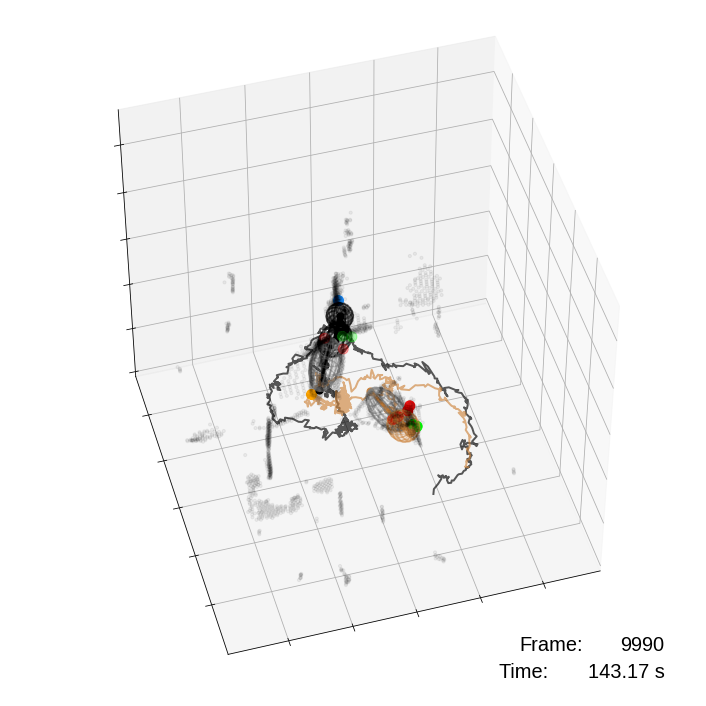

In [17]:
# Make example plots for smoothing!
# and add the smoothed and raw data to the video maker
from utils.analysis_tools import particles_to_body_supports_cuda,VideoPlotMachine,VideoPlotMachine_noimpl

if has_implant:
    Plotter = VideoPlotMachine_noimpl(tracked_behavior,jagged_lines, has_implant=has_implant)
else:
    Plotter = VideoPlotMachine_noimpl(tracked_behavior,jagged_lines)
self = Plotter

# add the smoothed coordinates as numpy arrays
self.body_support_0_raw = [i.cpu().numpy().squeeze() for i in body_support_0]
self.body_support_0_smooth = body_support_0_smooth
self.s_0_raw = s_0
self.s_0_smooth = s_0_smooth
self.body_support_1_raw = [i.cpu().numpy().squeeze() for i in body_support_1]
self.body_support_1_smooth = body_support_1_smooth
self.s_1_raw = s_1
self.s_1_smooth = s_1_smooth
# also smooth the body ellipsoid rotations
self.body_support_0_smooth = smooth_rotation_matrices(body_support_0_smooth)
self.body_support_1_smooth = smooth_rotation_matrices(body_support_1_smooth)

# self.body_support_0_smooth = smooth_rotation_matrices_quaternion(body_support_0_smooth)
# self.body_support_1_smooth = smooth_rotation_matrices_quaternion(body_support_1_smooth)

frame_list = np.arange(20*fps,5*60*fps,10).astype('int')
frame_list = np.arange(200,10000-1,10).astype('int')

real_fps = 60
stepping = 20
view_fps = real_fps/stepping

frame_list = np.arange(tracked_behavior['start_frame'],tracked_behavior['end_frame']-1,10).astype('int')
frame_list = np.arange(tracked_behavior['start_frame'],10000-1,stepping).astype('int')

# self.make_me(frame_list[0],cloud = True,skel='smooth',ellip='smooth',
#              trace='smooth',view_override = [90,0],savepath='figs/with_implant.pdf') #47.74, 25.86

# self.video_me(frame_list=frame_list, savepath = 'videos/example_raw.mp4',
#               trace='raw',skel='raw',ellip='raw',view_override = [47,74],fps = 10)

# self.video_me(frame_list=frame_list, savepath = 'videos/example_moo_closer.mp4',
#               trace='smooth',skel='smooth',ellip='smooth',view_override = [47,74],fps = 10)

self.video_me(frame_list=frame_list, savepath = 'videos/with_implant.mp4',
              trace='raw',skel='raw',ellip='raw',view_override = [47,74],fps = view_fps)
